# **Modelos Avanzados de Aprendizaje Automático I**


**Rafael Balseiro Couceiro** <br>
**Iván Mandayo Lagoa** <br>
**Alba ... ...**

# **Práctica 2: Reconocimiento de movimiento a partir de sensores de smartphones**

In [1]:
# Check enviroment
using Pkg
Pkg.status()

Status `~/Documents/Documents - Rafael’s MacBook Pro/Uni/CuatrI5/MAAA_1/practicas/p2/envP2/Project.toml`
  [336ed68f] CSV v0.10.15
  [324d7699] CategoricalArrays v1.0.2
  [a93c6f00] DataFrames v1.8.1
  [587475ba] Flux v0.16.5
  [38e38edf] GLM v1.9.0
  [09f84164] HypothesisTests v0.11.6
⌃ [7073ff75] IJulia v1.32.1
⌃ [f7bf1975] Impute v0.6.12
  [96684042] InformationMeasures v0.3.1
  [c8e1da08] IterTools v1.10.0
  [b1bec4e5] LIBSVM v0.8.1
  [add582a8] MLJ v0.22.0
  [a7f614a8] MLJBase v1.10.0
  [094fc8d1] MLJFlux v0.6.7
  [61c7150f] MLJLIBSVMInterface v0.2.2
  [6ee0df7b] MLJLinearModels v0.10.1
  [e80e1ace] MLJModelInterface v1.12.0
  [1b6a4a23] MLJMultivariateStatsInterface v0.5.4
  [6f286f6a] MultivariateStats v0.10.3
  [636a865e] NearestNeighborModels v0.2.3
  [3bd65402] Optimisers v0.4.6
  [ccf2f8ad] PlotThemes v3.3.0
⌃ [91a5bcdd] Plots v1.41.1
⌅ [08abe8d2] PrettyTables v2.4.0
  [10745b16] Statistics v1.11.1
  [2913bbd2] StatsBase v0.34.8
  [f3b207a7] StatsPlots v0.15.8
  [bd369af6] T

In [2]:
# Import necessary libraries
using DataFrames: groupby, combine, select!, Not, DataFrame, ncol, nrow, disallowmissing!
using MLJ
using MLJBase
using CSV
using Statistics
using Plots
using Random
using StatsBase
using IterTools
using Impute
using DataFrames
using StatsPlots
using CategoricalArrays
using Tables

In [3]:
Random.seed!(104) # For reproducibility

TaskLocalRNG()

## **Preparación de los datos**

### **1. Carga y unificación de los datos**

In [4]:
# Ruta raíz de los datos
DATA_PATH = "../data"

# Recorrer todos los directorios y subdirectorios, y extraer archivos CSV
csv_files = filter(f -> endswith(f, ".csv"), 
                   [joinpath(dir, file) for (dir, _, files) in walkdir(DATA_PATH) for file in files])

# Cargar todos los CSVs en un vector de DataFrames
dataframes = CSV.File.(csv_files) .|> DataFrame

# Concatenar todos los DataFrames en uno solo
full_dataset = vcat(dataframes...)

# Descripción básica
total_features = size(full_dataset, 2)
total_instances = size(full_dataset, 1)
total_individuals = size(unique(full_dataset.subject), 1)
total_targets = size(unique(full_dataset.Activity), 1)

println("Número de variables: ", total_features)
println("Número de instancias: ", total_instances)
println("Número de individuos: ", total_individuals)
println("Número de clases de salida: ", total_targets)



Número de variables: 563
Número de instancias: 10299
Número de individuos: 30
Número de clases de salida: 6


### **2. Análisis de missing values**

In [5]:
# Nombres de columnas
cols = names(full_dataset)
missing_counts = count.(ismissing, eachcol(full_dataset))

missing_percent = Dict(cols[i] => 100 * missing_counts[i] / total_instances for i in eachindex(cols))

# Porcentaje de missing total
total_missing_percent = 100 * sum(missing_counts) / (total_instances * ncol(full_dataset))

# Mostrar resultados
for (col, pct) in sort(collect(missing_percent), by=x->x[2], rev=true)
    if pct > 0.0
        println(col, ": ", round(pct, digits=2), "%")
    end
end

println("\nTotal Missing Values (%): ", round(total_missing_percent, digits=2), "%")

tBodyGyroMag-mad(): 10.03%
tBodyGyroMag-iqr(): 10.03%
fBodyAcc-mad()-Y: 10.02%
fBodyAccJerk-mean()-X: 10.02%
tGravityAccMag-std(): 10.0%
tBodyAccJerk-entropy()-Y: 10.0%
tBodyAccMag-max(): 10.0%
fBodyBodyGyroMag-iqr(): 10.0%
tBodyAccJerk-energy()-X: 10.0%
fBodyAcc-std()-X: 10.0%
tGravityAccMag-entropy(): 10.0%
fBodyAcc-maxInds-Y: 9.99%
tBodyAccJerkMag-arCoeff()2: 9.99%
tGravityAcc-arCoeff()-X,3: 9.99%
fBodyGyro-energy()-Y: 9.99%
fBodyGyro-bandsEnergy()-49,56.1: 9.99%
fBodyAccJerk-bandsEnergy()-1,8.1: 9.99%
fBodyAccJerk-bandsEnergy()-1,8: 9.99%
fBodyAccMag-max(): 9.99%
tGravityAcc-mad()-Z: 9.99%
tBodyGyroJerk-arCoeff()-Z,2: 9.99%
tBodyGyro-mean()-Z: 9.99%
fBodyAcc-bandsEnergy()-25,32.2: 9.99%
tBodyGyroJerkMag-arCoeff()1: 9.99%
fBodyAcc-kurtosis()-Y: 9.99%
tBodyAccJerk-arCoeff()-X,4: 9.99%
fBodyGyro-mean()-X: 9.99%
tBodyAcc-correlation()-X,Y: 9.99%
fBodyAccJerk-bandsEnergy()-49,56.2: 9.99%
fBodyAccJerk-bandsEnergy()-9,16.2: 9.99%
fBodyAccJerk-bandsEnergy()-1,24: 9.99%
fBodyAcc-min()-Z: 9.

In [6]:
# Threshold
threshold = 5.0

# Convertimos el diccionario a DataFrame
df_missing = DataFrame(Feature = collect(keys(missing_percent)),
                       MissingPct = collect(values(missing_percent)))

# Categorizar
high_missing = df_missing[df_missing.MissingPct .>= threshold, :]
low_missing  = df_missing[(df_missing.MissingPct .> 0) .& (df_missing.MissingPct .< threshold), :]
no_missing   = df_missing[df_missing.MissingPct .== 0, :]

# Crear tabla resumen
summary_table = DataFrame(
    Category = ["High Missing (>=5%)", "Low Missing (>0% & <5%)", "No Missing (0%)"],
    NumVariables = [nrow(high_missing), nrow(low_missing), nrow(no_missing)],
    MeanMissingPct = [mean(high_missing.MissingPct),
                      mean(low_missing.MissingPct),
                      mean(no_missing.MissingPct)],
    StdMissingPct = [std(high_missing.MissingPct),
                     std(low_missing.MissingPct),
                     std(no_missing.MissingPct)]
)

println(summary_table)


3×4 DataFrame
 Row │ Category                 NumVariables  MeanMissingPct  StdMissingPct 
     │ String                   Int64         Float64         Float64       
─────┼──────────────────────────────────────────────────────────────────────
   1 │ High Missing (>=5%)                56       9.9949        0.00917645
   2 │ Low Missing (>0% & <5%)           119       0.0201537     0.00921659
   3 │ No Missing (0%)                   388       0.0           0.0


### **3. Tratamiento de missing values**

Como hemos visto hay varias features con **valores faltantes**, nuestra estrategia de tratamiento será la siguiente:

- Se asume que los valores nulos siguen un esquema **MCAR** (*Missing Completely at Random*)
- **Threshold**: 5%.
- Si *null_percentage* >= 5%: eliminación de dicha feature.
- Sino si *null_percentage* < 5%: imputación por interpolación.

In [7]:
function impute_MCAR(df::DataFrame, missing_percent::Dict{String, Float64}, threshold::Float64=5.0)

    df_clean = deepcopy(df)

    cols = names(df_clean)
    # Reutilizamos el diccionario pasado como argumento
    pct_missing = [missing_percent[col] for col in cols]

    # Identificación de columnas
    to_drop   = cols[pct_missing .>= threshold]
    to_impute = cols[(pct_missing .> 0.0) .& (pct_missing .< threshold)]

    # 1. Eliminar columnas con exceso de missings
    select!(df_clean, Not(to_drop))

    # Informe
    imputed_cols = Dict{String,String}()

    # === IMPUTACIÓN POR INDIVIDUO (Interpolación Temporal) ===
    # Agrupamos por sujeto (vista)
    gdf = groupby(df_clean, :subject)

    for col in to_impute
        
        # Iteramos sobre los grupos (individuos)
        for subdf in gdf
            # Aplicar interpolación
            subdf[!, col] .= Impute.interp(subdf[!, col]) |> Impute.locf |> Impute.nocb
        end

        # Registrar imputación
        imputed_cols[col] = "linear_interpolation_by_subject"
    end

    # Eliminar el tipo Union{Missing, T} que puede fallar en el pipeline
    DataFrames.disallowmissing!(df_clean)

    # Reporte final
    report = Dict(
        "eliminated_columns" => to_drop,
        "imputed_columns"    => keys(imputed_cols),
        "num_eliminated"     => length(to_drop),
        "num_imputed"        => length(imputed_cols)
    )

    return df_clean, report
end

impute_MCAR (generic function with 2 methods)

Ahora, ya diseñado el pipeline de limpieza de valores nulos, lo aplicaremos:

In [8]:
# Suponiendo que full_dataset y missing_percent ya están definidos
threshold = 5.0
clean_df, imputation_report = impute_MCAR(full_dataset, missing_percent, threshold)

println("Dropped features: ", imputation_report["num_eliminated"])
println("Imputed features: ", imputation_report["num_imputed"])
println("New feature space dimension: ", size(clean_df, 2))

Dropped features: 56
Imputed features: 119
New feature space dimension: 507


Podemos observar que el número de columnas, tanto eliminadas como imputadas **coincide** con el análisis hecho con el dataset completo anteriormente.

Para asegurarnos por completo, contaremos el número de **missing values**, puediendo asegurar que es ahora **0**.

In [9]:
# Contar la cantidad de missing values
missing_values = sum(count.(ismissing, eachcol(clean_df)))
println("\nTotal Missing Values: ", missing_values)


Total Missing Values: 0


### **4. Partición del conjunto**

In [10]:
function train_test_split(df::DataFrame, test_size::Float64=0.1)

    Random.seed!(104) 
    individuals = unique(df.subject)
    Random.shuffle!(individuals)
    n_test = Int(floor(length(individuals) * test_size))
    test_individuals = individuals[1:n_test]
    train_individuals = individuals[(n_test+1):end]
    train_df = df[in.(df.subject, Ref(train_individuals)), :]
    test_df = df[in.(df.subject, Ref(test_individuals)), :]
    return (train_df, test_df)

end

train_test_split (generic function with 2 methods)

In [11]:
function cross_validation_folds(df::DataFrame, k::Int=5)
    
    Random.seed!(104)
    
    # 1. Asignación aleatoria de individuos a folds
    folds = 1:k
    individuals = unique(df.subject)
    k_folds = repeat(folds, Int(ceil(length(individuals)/k))) 
    k_folds = k_folds[1:length(individuals)] 
    k_folds = shuffle!(k_folds) 

    # Mapeo: ID Sujeto -> Número de Fold (1..k)
    individual_to_fold = Dict(ind => fold for (ind, fold) in zip(individuals, k_folds))
    
    # 2. Generar vector de asignación por fila
    # Para cada fila del DF, miramos a qué fold pertenece su sujeto
    row_fold_assignments = [individual_to_fold[s] for s in df.subject]
    
    # 3. Crear tuplas de índices (Train, Test)
    cv_folds_indices = Vector{Tuple{Vector{Int}, Vector{Int}}}()
    
    for i in 1:k
        # Test: Filas cuyo sujeto cayó en el fold 'i'
        test_idx = findall(row_fold_assignments .== i)
        
        # Train: Filas cuyo sujeto cayó en cualquier OTRO fold
        train_idx = findall(row_fold_assignments .!= i)
        
        push!(cv_folds_indices, (train_idx, test_idx))
    end
    
    return cv_folds_indices    
end

cross_validation_folds (generic function with 2 methods)

In [12]:
train, test = train_test_split(clean_df, 0.1)

# Verificar datasets
println("Individuals in train set: ", length(unique(train.subject)))
println("Individuals in test set: ", length(unique(test.subject)), " | ", unique(test.subject))

println("Train set size: ", size(train))
println("Test set size: ", size(test))

Individuals in train set: 27
Individuals in test set: 3 | [25, 18, 22]
Train set size: (9205, 507)
Test set size: (1094, 507)


In [13]:
# --- Cross-Validation Folds Verification ---

# Generate folds (assuming 'train' DataFrame and 'cross_validation_folds' function exist)
folds = cross_validation_folds(train, 5)

println("CROSSVALIDATION CHECK (INDIVIDUAL-WISE)")
println("="^80)

# Iterating through fold tuples: [(train_idx, test_idx), ...]
for (i, (train_idx, test_idx)) in enumerate(folds)
    
    # Materialize data subsets using indices
    fold_train = train[train_idx, :]
    fold_test  = train[test_idx, :]
    
    # Extract unique subjects in each partition
    subjects_train = sort(unique(fold_train.subject))
    subjects_test  = sort(unique(fold_test.subject))
    
    # Check for intersection (Data Leakage)
    leakage = intersect(subjects_train, subjects_test)
    
    # Print Fold Report
    println("\n[Fold $i]")
    println("  Test Set:       Dimensions: $(size(fold_test))  | Subjects: $subjects_test")
    
    println("-"^80)
end

println("Verification completed.")

CROSSVALIDATION CHECK (INDIVIDUAL-WISE)

[Fold 1]
  Test Set:       Dimensions: (2171, 507)  | Subjects: [6, 7, 16, 21, 24, 30]
--------------------------------------------------------------------------------

[Fold 2]
  Test Set:       Dimensions: (1947, 507)  | Subjects: [2, 9, 10, 13, 26, 29]
--------------------------------------------------------------------------------

[Fold 3]
  Test Set:       Dimensions: (1823, 507)  | Subjects: [1, 17, 20, 23, 28]
--------------------------------------------------------------------------------

[Fold 4]
  Test Set:       Dimensions: (1662, 507)  | Subjects: [3, 5, 12, 14, 27]
--------------------------------------------------------------------------------

[Fold 5]
  Test Set:       Dimensions: (1602, 507)  | Subjects: [4, 8, 11, 15, 19]
--------------------------------------------------------------------------------
Verification completed.


### **5. Exploratory Data Analysis**

Realizaremos un análisis básico de los datos que constará de:

- Exploración de la **distribución de las clases** a lo largo del dataset, lo cuál nos dará información sobre qué métricas emplear.
- **Visualización** de la proyección de los datos en un espacio de **baja dimensionalidad**.

In [14]:
theme(:wong)

In [15]:
# --- 1. Agregación Global (Distribución de clases) ---
activity_counts = combine(groupby(train, :Activity), nrow => :Count)
sort!(activity_counts, :Count, rev=true) # Orden descendente 

# --- 2. Preparación Matriz Sujeto-Actividad (Heatmap) ---
# Agrupar y pivotar
subj_activity_df = combine(groupby(train, [:subject, :Activity]), nrow => :Count)
pivot_df = unstack(subj_activity_df, :subject, :Activity, :Count, fill=0)
sort!(pivot_df, :subject) # Asegurar orden numérico de sujetos

# Extraer matriz y ejes para el plot
heatmap_matrix = Matrix(pivot_df[:, Not(:subject)])
activities_x   = names(pivot_df, Not(:subject))

# Eje Y: CategoricalArray para forzar orden numérico (1, 2... 10) y no string (1, 10, 2...)
subjects_y = pivot_df.subject
subjects_categorical = categorical(string.(subjects_y), levels=string.(subjects_y), ordered=true)

27-element CategoricalArray{String,1,UInt32}:
 "1"
 "2"
 "3"
 "4"
 "5"
 "6"
 "7"
 "8"
 "9"
 "10"
 "11"
 "12"
 "13"
 ⋮
 "16"
 "17"
 "19"
 "20"
 "21"
 "23"
 "24"
 "26"
 "27"
 "28"
 "29"
 "30"

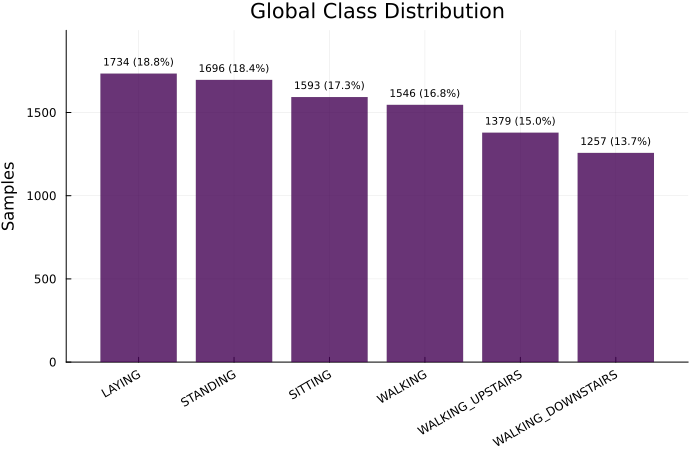

Imbalance Ratio: 1.38


In [16]:
# Métricas de desbalanceo
min_c, max_c = extrema(activity_counts.Count)
imbalance_ratio = max_c / min_c

# Preparar etiquetas con %
total_n = sum(activity_counts.Count)
pcts = round.((activity_counts.Count ./ total_n) * 100, digits=1)
bar_labels = string.(activity_counts.Count, " (", pcts, "%)")

# Visualización
p_global = bar(
    activity_counts.Activity, activity_counts.Count,
    title = "Global Class Distribution",
    xlabel = "Activity Class", ylabel = "Samples",
    color = :viridis, alpha = 0.8, legend = false,
    xrotation = 30, linewidth = 0,
    ylim = (0, max_c * 1.15), # Margen superior para etiquetas
    size = (700, 450)
)

# Anotaciones sobre barras
anns = [(x, y + (max_c*0.02), text(lbl, 7, :black, :bottom)) 
        for (x, y, lbl) in zip(activity_counts.Activity, activity_counts.Count, bar_labels)]
annotate!(anns)

display(p_global)
println("Imbalance Ratio: $(round(imbalance_ratio, digits=2))")

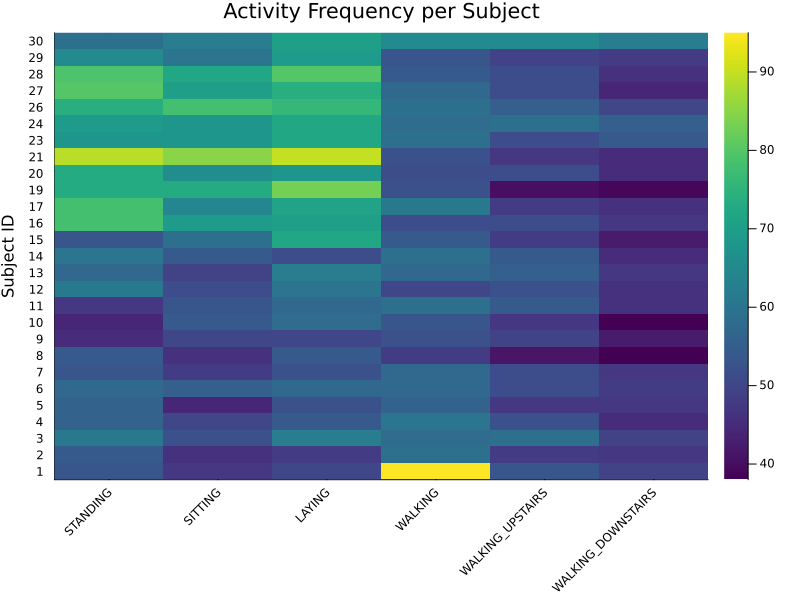

In [17]:
p_heatmap = heatmap(
    activities_x, subjects_categorical, heatmap_matrix,
    title  = "Activity Frequency per Subject",
    xlabel = "Activity", ylabel = "Subject ID",
    color = :viridis,
    xrotation = 45,
    size = (800, 600)
)

display(p_heatmap)

### **6. Conversión de datos para el pipeline**

Qué hacemos en esta fase del preprocesado:

- Convertir datos a **Tables** en lugar de DataFrames.
- Convertir el vector de labels a vector categórcio con **label encoding** 

In [14]:
# 1. Feature Extraction (X)
# Transformación a ColumnTable (NamedTuple de vectores) para eficiencia en memoria
data_tbl = Tables.columntable(train)

# Filtrado de columnas de metadatos (ID y Target)
ignore_cols = (:subject, :Activity)
feature_cols = filter(k -> k ∉ ignore_cols, keys(data_tbl))

# Construcción de X como NamedTuple limpia
X_train = NamedTuple{feature_cols}(data_tbl)

# 2. Target Encoding (y)
# Definición explícita de ordinalidad
activity_levels = [
    "LAYING", "SITTING", "STANDING", 
    "WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS"
]

# Conversión a CategoricalArray ordenado
# MLJ prefiere Categorical{String} con orden definido antes que raw Integers
y_raw = Tables.getcolumn(data_tbl, :Activity)
y_train = categorical(y_raw, levels=activity_levels, ordered=true)

# Sanity checks
println("X Type:      ", typeof(X_train))
println("y Scitype:   ", scitype(y_train)) # Verificar compatibilidad con MLJ (OrderedFactor)
println("y Levels:    ", levels(y_train))

X Type:      @NamedTuple{var"tBodyAcc-mean()-X"::Vector{Float64}, var"tBodyAcc-mean()-Y"::Vector{Float64}, var"tBodyAcc-mean()-Z"::Vector{Float64}, var"tBodyAcc-std()-X"::Vector{Float64}, var"tBodyAcc-std()-Y"::Vector{Float64}, var"tBodyAcc-std()-Z"::Vector{Float64}, var"tBodyAcc-mad()-X"::Vector{Float64}, var"tBodyAcc-mad()-Y"::Vector{Float64}, var"tBodyAcc-mad()-Z"::Vector{Float64}, var"tBodyAcc-max()-X"::Vector{Float64}, var"tBodyAcc-max()-Y"::Vector{Float64}, var"tBodyAcc-max()-Z"::Vector{Float64}, var"tBodyAcc-min()-X"::Vector{Float64}, var"tBodyAcc-min()-Y"::Vector{Float64}, var"tBodyAcc-min()-Z"::Vector{Float64}, var"tBodyAcc-sma()"::Vector{Float64}, var"tBodyAcc-energy()-X"::Vector{Float64}, var"tBodyAcc-energy()-Y"::Vector{Float64}, var"tBodyAcc-energy()-Z"::Vector{Float64}, var"tBodyAcc-iqr()-X"::Vector{Float64}, var"tBodyAcc-iqr()-Y"::Vector{Float64}, var"tBodyAcc-iqr()-Z"::Vector{Float64}, var"tBodyAcc-entropy()-X"::Vector{Float64}, var"tBodyAcc-entropy()-Y"::Vector{Float64

## **Modelos básicos: entrenamiento con crossvalidation + tests estadísticos**

In [15]:
include("../src/filterWrappers.jl")
include("../src/dimReduction.jl")
include("../src/modelFactory.jl")
include("../src/experimentLab.jl")
include("../src/scaler.jl")
include("../src/resultAnalysis.jl")
include("../src/hypothesisTest.jl")

using .FilteringReduction: PearsonSelector, SpearmanSelector, KendallSelector, ANOVASelector, MutualInfoSelector
using .ProyectionReduction: get_lda_model, get_pca_model, get_ica_model
using .ModelFactory: get_knn_model, get_svm_model, get_mlp_model
using .ExperimentLab: run_experiment_crossvalidation, History
using .CustomScalers: MinMaxScaler
using .ResultAnalysis: display_cv_table, plot_cv_results
using .StatisticalTests: auto_compare_models

[ Info: For silent loading, specify `verbosity=0`. 


import MLJLinearModels ✔


In [16]:
SCALER = MinMaxScaler()
METRICS = Dict(
    "Accuracy" => Accuracy(),
    "F1_Macro" => MulticlassFScore(beta=1.0, average=MacroAvg())
)

Dict{String, StatisticalMeasuresBase.FussyMeasure{M, Nothing} where M} with 2 entries:
  "Accuracy" => Accuracy()
  "F1_Macro" => MulticlassFScore(beta = 1.0, …)

In [17]:
function run_scenarios_cv(scenarios)

    results = History[]

    for (tag, filter, reducer, model) in scenarios
        try
            history = run_experiment_crossvalidation(
                SCALER, 
                filter, 
                reducer, 
                model, 
                X_train, y_train, folds;
                tag = tag, 
                metrics = METRICS
            )

            push!(results, history)
        catch e
            println("Error en el escenario: $tag")
            println(e)
        end
    end

    # Mostrar resultados
    display_cv_table(results, ["Accuracy", "F1_Macro"])

    p = plot_cv_results(results, "F1_Macro")
    display(p)

    return results

end

run_scenarios_cv (generic function with 1 method)

### **K Nearest Neighbors**

Exp: KNN_1_ANOVA_PCA   Topología: {505} -> {100.0 ± 0.0} -> {15.0 ± 0.0}     Accuracy: 0.8118 ± 0.0114     F1_Macro: 0.8072 ± 0.0139
Exp: KNN_10_MI_LDA   Topología: {505} -> {100.0 ± 0.0} -> {5.0 ± 0.0}     Accuracy: 0.817 ± 0.0337     F1_Macro: 0.8266 ± 0.032
Exp: KNN_20_kendall   Topología: {505} -> {100.0 ± 0.0} -> {100.0 ± 0.0}     Accuracy: 0.7454 ± 0.0093     F1_Macro: 0.7556 ± 0.011
┌─────────────────┬─────────────────┬────────────────┬─────────────────┬────────────────┐
│ Experiment      │ Accuracy (mean) │ Accuracy (std) │ F1_Macro (mean) │ F1_Macro (std) │
├─────────────────┼─────────────────┼────────────────┼─────────────────┼────────────────┤
│ KNN_10_MI_LDA   │ 0.8170          │ 0.0337         │ 0.8266          │ 0.0320         │
│ KNN_1_ANOVA_PCA │ 0.8118          │ 0.0114         │ 0.8072          │ 0.0139         │
│ KNN_20_kendall  │ 0.7454          │ 0.0093         │ 0.7556          │ 0.0110         │
└─────────────────┴─────────────────┴────────────────┴─────────────

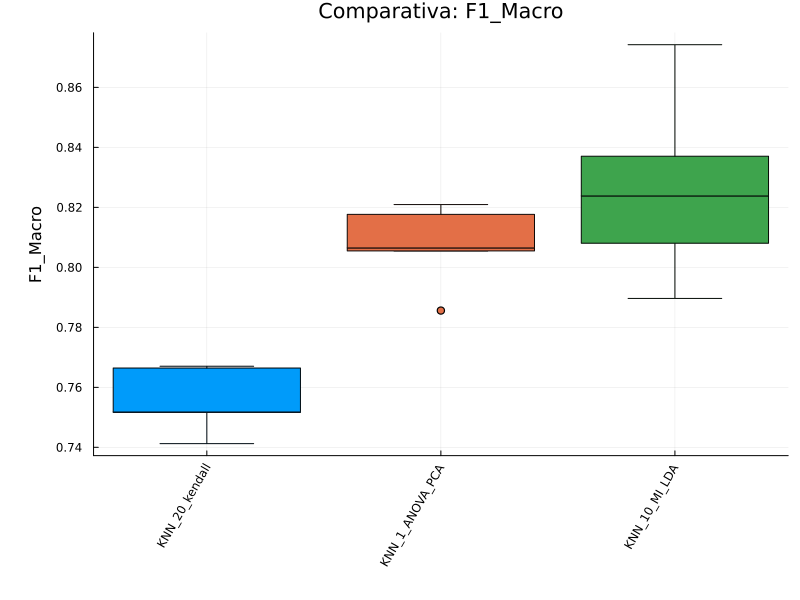

3-element Vector{History}:
 History("KNN_1_ANOVA_PCA", Dict{String, Any}("Accuracy" => [0.806540764624597, 0.8233179250128403, 0.7948436642896325, 0.8200962695547533, 0.8139825218476904], "F1_Macro" => [0.8054788600109236, 0.8209437733900173, 0.7855945411825329, 0.8176613523135455, 0.8064855284834126]), 505, (100.0, 0.0), (15.0, 0.0))
 History("KNN_10_MI_LDA", Dict{String, Any}("Accuracy" => [0.8139106402579457, 0.8685156651258347, 0.8244651673066374, 0.8002406738868832, 0.7777777777777778], "F1_Macro" => [0.8238154889158686, 0.8742238556078933, 0.8370543296922495, 0.8080435275054983, 0.7896474817527388]), 505, (100.0, 0.0), (5.0, 0.0))
 History("KNN_20_kendall", Dict{String, Any}("Accuracy" => [0.751727314601566, 0.7421674370826913, 0.7569939659901261, 0.7328519855595668, 0.7434456928838952], "F1_Macro" => [0.7670264428441561, 0.7517892384130815, 0.766447093384897, 0.7412246098962556, 0.7516618496350478]), 505, (100.0, 0.0), (100.0, 0.0))

In [18]:
SCENARIOS_KNN = [
    ("KNN_1_ANOVA_PCA", ANOVASelector(k = 100), get_pca_model(outdim=15), get_knn_model(1)),
    ("KNN_10_MI_LDA", MutualInfoSelector(k = 100), get_lda_model(outdim=5), get_knn_model(10)),
    ("KNN_20_kendall", KendallSelector(k=100), nothing, get_knn_model(20)), 
]

resuls_knn = run_scenarios_cv(SCENARIOS_KNN)

In [19]:
auto_compare_models(resuls_knn, "F1_Macro")

┌ Warning: This test is only asymptotically correct and might be inaccurate for the given group size
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/FtZtp/src/kruskal_wallis.jl:73



--- Test de Kruskal-Wallis (Global) ---
Hipótesis Nula (H0): Las medianas de los grupos son iguales.
p-value: 0.00604
Resultado: Se rechaza H0 (Diferencias significativas).

--- Comparativa por Pares (Wilcoxon Signed-Rank) ---
Referencia: KNN_10_MI_LDA (Media: 0.8266)
┌─────────────────┬────────┬────────────┬─────────┬───────────────┐
│ Modelo          │ Media  │ Diferencia │ P_Value │ Significativo │
├─────────────────┼────────┼────────────┼─────────┼───────────────┤
│ KNN_1_ANOVA_PCA │ 0.8072 │ 0.0193     │ 0.3125  │ No            │
│ KNN_20_kendall  │ 0.7556 │ 0.0709     │ 0.0625  │ No            │
└─────────────────┴────────┴────────────┴─────────┴───────────────┘



### **Multilayer Perceptron**

Exp: MLP_[50]_Pearson_PCA   Topología: {505} -> {400.0 ± 0.0} -> {90.0 ± 0.0}     Accuracy: 0.9417 ± 0.0155     F1_Macro: 0.9416 ± 0.0153
Exp: MLP_[100]_Spearman_ICA   Topología: {505} -> {25.0 ± 0.0} -> {10.0 ± 0.0}     Accuracy: 0.6618 ± 0.0375     F1_Macro: 0.6708 ± 0.0426
Exp: MLP_[100, 50]_baseline   Topología: {505} -> {505.0 ± 0.0} -> {505.0 ± 0.0}     Accuracy: 0.9215 ± 0.025     F1_Macro: 0.9211 ± 0.0245
┌────────────────────────┬─────────────────┬────────────────┬─────────────────┬────────────────┐
│ Experiment             │ Accuracy (mean) │ Accuracy (std) │ F1_Macro (mean) │ F1_Macro (std) │
├────────────────────────┼─────────────────┼────────────────┼─────────────────┼────────────────┤
│ MLP_[50]_Pearson_PCA   │ 0.9417          │ 0.0155         │ 0.9416          │ 0.0153         │
│ MLP_[100, 50]_baseline │ 0.9215          │ 0.0250         │ 0.9211          │ 0.0245         │
│ MLP_[100]_Spearman_ICA │ 0.6618          │ 0.0375         │ 0.6708          │ 0.0426         │
└

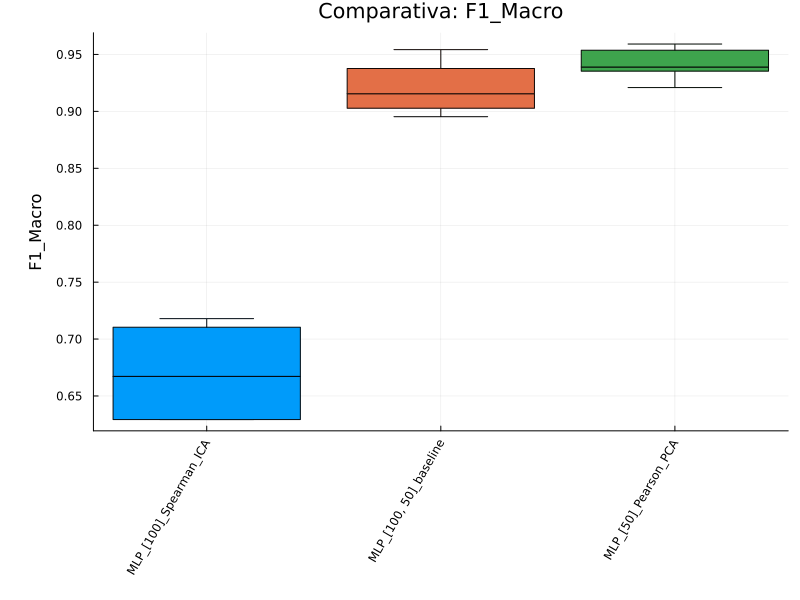

3-element Vector{History}:
 History("MLP_[50]_Pearson_PCA", Dict{String, Any}("Accuracy" => [0.9378166743436205, 0.9352850539291218, 0.9539221064179924, 0.9211793020457281, 0.9600499375780275], "F1_Macro" => [0.9390237227199894, 0.9353358103876709, 0.9537396344955164, 0.9209003033796781, 0.9591704268950003]), 505, (400.0, 0.0), (90.0, 0.0))
 History("MLP_[100]_Spearman_ICA", Dict{String, Any}("Accuracy" => [0.7033625057577153, 0.6286594761171033, 0.6604498080087767, 0.6209386281588448, 0.6953807740324595], "F1_Macro" => [0.7179349599183663, 0.6292984149962689, 0.6671975186056708, 0.6292852566253304, 0.7103780957484479]), 505, (25.0, 0.0), (10.0, 0.0))
 History("MLP_[100, 50]_baseline", Dict{String, Any}("Accuracy" => [0.8935974205435283, 0.9157678479712378, 0.9539221064179924, 0.9043321299638989, 0.9400749063670412], "F1_Macro" => [0.8953568593866591, 0.915525403140126, 0.9542666273963784, 0.9027460749386014, 0.9376829727438186]), 505, (505.0, 0.0), (505.0, 0.0))

In [20]:
SCENARIOS_MLP = [
    ("MLP_[50]_Pearson_PCA", PearsonSelector(k = 400), get_pca_model(outdim=90), get_mlp_model([50]; epochs=30)),
    ("MLP_[100]_Spearman_ICA", SpearmanSelector(k = 25), get_ica_model(outdim=10, maxiter=10000, tol=0.5), get_mlp_model([100]; epochs=30)),
    ("MLP_[100, 50]_baseline", nothing, nothing, get_mlp_model([100, 50]; epochs=30)), 
]

results_mlp = run_scenarios_cv(SCENARIOS_MLP)

In [21]:
auto_compare_models(results_mlp, "F1_Macro")


--- Test de Kruskal-Wallis (Global) ---
Hipótesis Nula (H0): Las medianas de los grupos son iguales.
p-value: 0.00604
Resultado: Se rechaza H0 (Diferencias significativas).

--- Comparativa por Pares (Wilcoxon Signed-Rank) ---
Referencia: MLP_[50]_Pearson_PCA (Media: 0.9416)
┌────────────────────────┬────────┬────────────┬─────────┬───────────────┐
│ Modelo                 │ Media  │ Diferencia │ P_Value │ Significativo │
├────────────────────────┼────────┼────────────┼─────────┼───────────────┤
│ MLP_[100, 50]_baseline │ 0.9211 │ 0.0205     │ 0.125   │ No            │
│ MLP_[100]_Spearman_ICA │ 0.6708 │ 0.2708     │ 0.0625  │ No            │
└────────────────────────┴────────┴────────────┴─────────┴───────────────┘



┌ Warning: This test is only asymptotically correct and might be inaccurate for the given group size
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/FtZtp/src/kruskal_wallis.jl:73


### **Suport Vector Machine**

In [ ]:
SCENARIOS_SVM = [
    ("MLP_[50]_Pearson_PCA", PearsonSelector(k = 400), get_pca_model(outdim=90), get_svm_model(0.1)),
    ("MLP_[100]_Spearman_ICA", SpearmanSelector(k = 25), get_ica_model(outdim=10, maxiter=10000, tol=0.5), get_svm_model(0.5)),
    ("MLP_[100, 50]_baseline", nothing, nothing, get_svm_model(1.0)), 
]

results_svm = run_scenarios_cv(SCENARIOS_SVM)

In [ ]:
auto_compare_models(results_mlp, "F1_Macro")

### **Prueba -> RFE**